## Part 1: Set-up

### Load APIs

In [1]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
from tf_utils import weight_variable, bias_variable, dense_to_one_hot
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load data

In [2]:
mnist_cluttered = np.load('./data/mnist_sequence1_sample_5distortions5x5.npz')

X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test  = mnist_cluttered['X_test']
y_test  = mnist_cluttered['y_test']

### Turn labels from dense to one hot representation

In [3]:
Y_train = dense_to_one_hot(y_train, n_classes=10)
Y_valid = dense_to_one_hot(y_valid, n_classes=10)
Y_test  = dense_to_one_hot(y_test, n_classes=10)

## Part 2: Problem

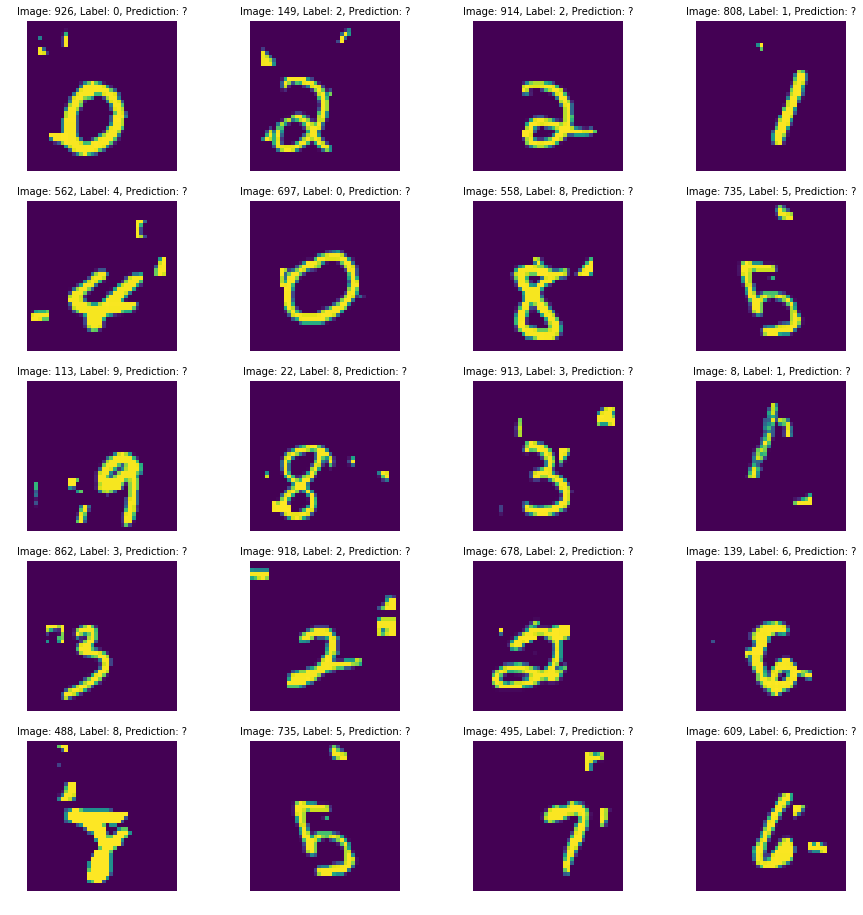

In [4]:
np.random.seed = 99
example_indices = np.random.randint(1, 1000, size=20)

ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.2)
for index in example_indices:
    plt.subplot(5, 4, ith + 1)
    plt.imshow(mnist_cluttered['X_test'].reshape(1000, 40, 40)[index, ...])
    
    truth = mnist_cluttered['y_test'][index][0]
    
    plt.title("Image: {}, Label: {}, Prediction: ?".format(index, truth), {'fontsize': 10})
    plt.axis('off')
    ith += 1

## Part 3: Localization Network

### Create placeholders

#### Key idea:

Placeholders for 40x40 resolution input images.

In [5]:
tf.set_random_seed(1)
x = tf.placeholder(tf.float32, [None, 1600])
y = tf.placeholder(tf.float32, [None, 10])

### Reshape inputs

#### Key idea:

Since x is currently \[batch, height*width\], we need to reshape to a 4-D tensor to use it in a convolutional graph. If one component of ```shape``` is the special value -1, the size of that dimension is computed so that the total size remains constant. Since we haven't defined the batch dimension's shape yet, we use -1 to denote this dimension should not change size.

In [6]:
x_tensor = tf.reshape(x, [-1, 40, 40, 1])

### Setup a two-layer localisation network

#### Key idea:

Setup the two-layer localisation network to figure out the parameters for an affine transformation of the input. Use identity transformation as starting point.

In [7]:
# Identity transformation
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32')
initial = initial.flatten()

# Create variables for fully-connected layer for the localisation network
W_fc_loc1 = weight_variable([1600, 20])
b_fc_loc1 = bias_variable([20])

W_fc_loc2 = weight_variable([20, 6])
b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')

### Define a two layer localisation network

#### Key idea:

Use activation function (Tanh) for first and second local layers. Add regularization technique (dropout) in anticipation for overfitting.

In [9]:
# First layer
h_fc_loc1 = tf.nn.tanh(tf.matmul(x, W_fc_loc1) + b_fc_loc1)

# Dropout for regularization
keep_prob = tf.placeholder(tf.float32)
h_fc_loc1_drop = tf.nn.dropout(h_fc_loc1, keep_prob)

# Second layer
h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1_drop, W_fc_loc2) + b_fc_loc2)

### Create a spatial transformer module

In [10]:
out_size = (40, 40)
h_trans = transformer(x_tensor, h_fc_loc2, out_size)

## Part 4: Convolutional Layers

#### Key idea:

Design a simple two layer convolutional network.

### Build the first layer of convolution

#### Key idea:

Define our stride as batch $\times$ height $\times$ width $\times$ channels instead of pooling, we use strides of 2 and more layers with smaller filters.

In [11]:
# Weight matrix is [height, width, input_channels, output_channels]
filter_size = 3
n_filters_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 1, n_filters_1])

# Bias is [output_channels]
b_conv1 = bias_variable([n_filters_1])

# Activation Function
h_conv1 = tf.nn.relu(tf.nn.conv2d(input=h_trans, filter=W_conv1, strides=[1, 2, 2, 1], padding='SAME') + b_conv1)

### Build the second layer of convolution

In [12]:
n_filters_2 = 16
W_conv2 = weight_variable([filter_size, filter_size, n_filters_1, n_filters_2])
b_conv2 = bias_variable([n_filters_2])
h_conv2 = tf.nn.relu(tf.nn.conv2d(input=h_conv1, filter=W_conv2, strides=[1, 2, 2, 1], padding='SAME') + b_conv2)

### Connect the convolutional layers with a fully-connected layer

In [13]:
# Reshape to the fully-connected layer
h_conv2_flat = tf.reshape(h_conv2, [-1, 10 * 10 * n_filters_2])

# Create the fully-connected layer
n_fc = 1024
W_fc1 = weight_variable([10 * 10 * n_filters_2, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

# Add additional regularization
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Add a softmax layer for predicted probabilities

In [14]:
W_fc2 = weight_variable([n_fc, 10])
b_fc2 = bias_variable([10])
y_logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
scores = tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=y)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Part 5: Loss, Optimizatin, and Evaluation

### Define loss and optimizer

In [15]:
# Loss
cross_entropy = tf.reduce_mean(scores)

# Optimizer
opt = tf.train.AdamOptimizer()

# Minimize
optimizer = opt.minimize(cross_entropy)

# Gradients
grads = opt.compute_gradients(cross_entropy, [b_fc_loc2])

### Monitor accuracy

In [16]:
predictions = tf.argmax(y_logits, 1)
correct_prediction = tf.equal(tf.argmax(y_logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

results_fmt = '[{%H:%M%S}] EPOCH {}/{} LOSS {:.3f}, DEV: {:.3f}'

## Create and Run Session

#### Key idea:

Standard tensorflow boilerplate code to create and run a session.

### Initialize session

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Train parameters

In [18]:
# We'll now train in minibatches and report accuracy, loss:
iter_per_epoch = 100
n_epochs = 20 # Feel free to increase the epochs for better results
train_size = 10000

indices = np.linspace(0, 10000 - 1, iter_per_epoch)
indices = indices.astype('int')

### Train model

In [20]:
results_fmt = '[{:%H:%M%S}] EPOCH {}, ITERATION {}/{}, LOSS {:.3f}'

for epoch_i in range(n_epochs):
    for iter_i in range(iter_per_epoch - 1):
        batch_xs = X_train[indices[iter_i] : indices[iter_i + 1]]
        batch_ys = Y_train[indices[iter_i] : indices[iter_i + 1]]
        
        if iter_i % 10 == 0:
            loss = sess.run(cross_entropy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
            print(results_fmt.format(datetime.now(), epoch_i, iter_i, iter_per_epoch, loss))
            
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.8})
        
    val_acc = sess.run(accuracy, feed_dict={x: X_valid, y: Y_valid, keep_prob: 1.0})
    
    print('--------> {}/{} EPOCHS, VAL ACC: {:.3f}'.format(epoch_i + 1, n_epochs, val_acc))
    
test_acc, test_predictions = sess.run([accuracy, predictions], feed_dict={x: X_test, y: Y_test, keep_prob: 1.0})

[22:3741] EPOCH 0, ITERATION 0/100, LOSS 2.302
[22:3742] EPOCH 0, ITERATION 10/100, LOSS 2.299
[22:3742] EPOCH 0, ITERATION 20/100, LOSS 2.296
[22:3742] EPOCH 0, ITERATION 30/100, LOSS 2.303
[22:3743] EPOCH 0, ITERATION 40/100, LOSS 2.302
[22:3743] EPOCH 0, ITERATION 50/100, LOSS 2.300
[22:3743] EPOCH 0, ITERATION 60/100, LOSS 2.300
[22:3744] EPOCH 0, ITERATION 70/100, LOSS 2.292
[22:3744] EPOCH 0, ITERATION 80/100, LOSS 2.271
[22:3745] EPOCH 0, ITERATION 90/100, LOSS 2.253
--------> 1/20 EPOCHS, VAL ACC: 0.223
[22:3745] EPOCH 1, ITERATION 0/100, LOSS 2.204
[22:3746] EPOCH 1, ITERATION 10/100, LOSS 2.168
[22:3746] EPOCH 1, ITERATION 20/100, LOSS 2.088
[22:3746] EPOCH 1, ITERATION 30/100, LOSS 2.088
[22:3747] EPOCH 1, ITERATION 40/100, LOSS 1.926
[22:3747] EPOCH 1, ITERATION 50/100, LOSS 1.753
[22:3747] EPOCH 1, ITERATION 60/100, LOSS 1.783
[22:3748] EPOCH 1, ITERATION 70/100, LOSS 1.736
[22:3748] EPOCH 1, ITERATION 80/100, LOSS 1.494
[22:3749] EPOCH 1, ITERATION 90/100, LOSS 1.549
----

[22:3839] EPOCH 15, ITERATION 80/100, LOSS 0.146
[22:3840] EPOCH 15, ITERATION 90/100, LOSS 0.134
--------> 16/20 EPOCHS, VAL ACC: 0.925
[22:3840] EPOCH 16, ITERATION 0/100, LOSS 0.197
[22:3841] EPOCH 16, ITERATION 10/100, LOSS 0.134
[22:3841] EPOCH 16, ITERATION 20/100, LOSS 0.161
[22:3841] EPOCH 16, ITERATION 30/100, LOSS 0.169
[22:3842] EPOCH 16, ITERATION 40/100, LOSS 0.105
[22:3842] EPOCH 16, ITERATION 50/100, LOSS 0.257
[22:3842] EPOCH 16, ITERATION 60/100, LOSS 0.164
[22:3843] EPOCH 16, ITERATION 70/100, LOSS 0.155
[22:3843] EPOCH 16, ITERATION 80/100, LOSS 0.104
[22:3843] EPOCH 16, ITERATION 90/100, LOSS 0.208
--------> 17/20 EPOCHS, VAL ACC: 0.923
[22:3844] EPOCH 17, ITERATION 0/100, LOSS 0.212
[22:3844] EPOCH 17, ITERATION 10/100, LOSS 0.114
[22:3845] EPOCH 17, ITERATION 20/100, LOSS 0.157
[22:3845] EPOCH 17, ITERATION 30/100, LOSS 0.102
[22:3845] EPOCH 17, ITERATION 40/100, LOSS 0.187
[22:3846] EPOCH 17, ITERATION 50/100, LOSS 0.194
[22:3846] EPOCH 17, ITERATION 60/100, LOSS

## Part 7: Evaluate

### Accuracy

In [21]:
test_acc, test_predictions = sess.run([accuracy, predictions], feed_dict={x: X_test, y: Y_test, keep_prob: 1.0})
print(test_acc)

0.94


### Inspect results

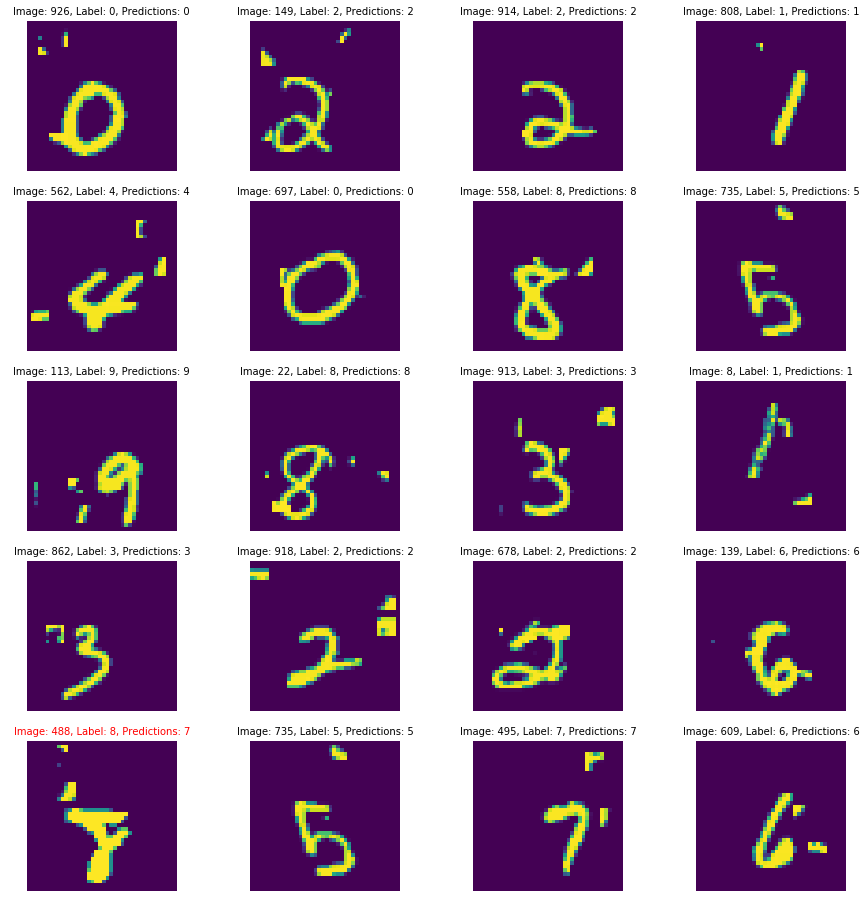

In [22]:
ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.2)
for index in example_indices:
    plt.subplot(5, 4, ith + 1)
    plt.imshow(mnist_cluttered['X_test'].reshape(1000, 40, 40)[index, ...])
    
    truth = mnist_cluttered['y_test'][index][0]
    pred = test_predictions[index]
    
    if truth == pred:
        label_color = 'black'
    else:
        label_color = 'red'
        
    plt.title("Image: {}, Label: {}, Predictions: {}". format(index, truth, pred), {'fontsize': 10}, color=label_color)
    plt.axis('off')
    ith += 1

### After Spatial Transformer

In [29]:
spt = sess.run(h_trans, feed_dict={x: X_test, keep_prob: 1.0})
print(spt.shape)

(1000, 40, 40, 1)


### Visualize h_trans

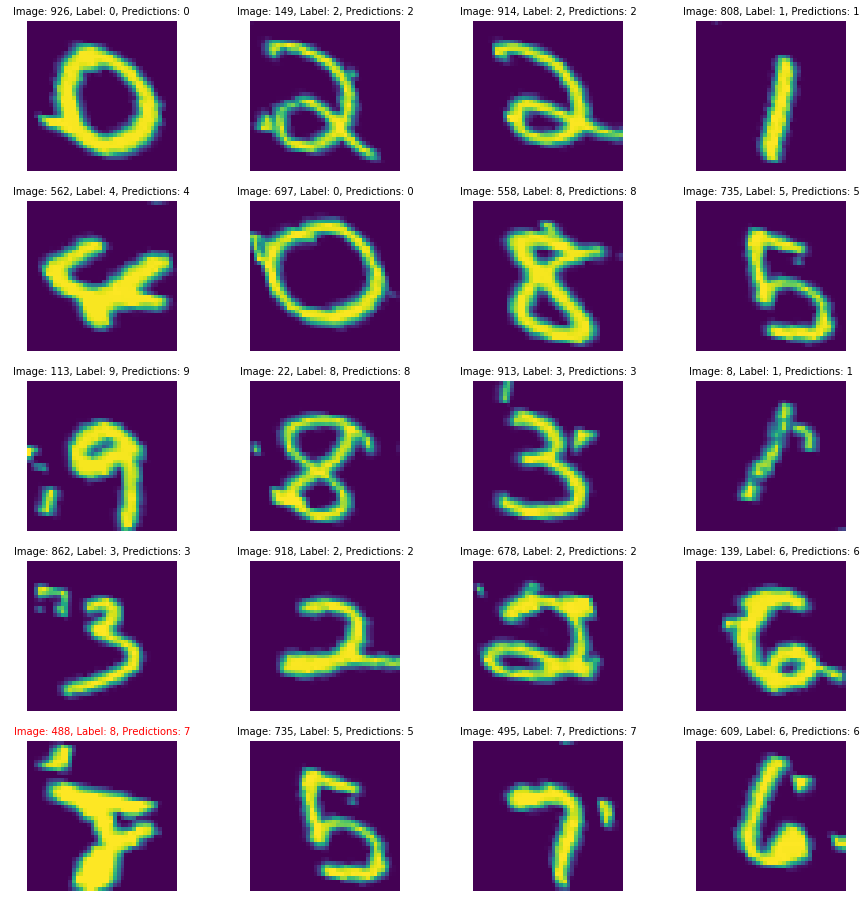

In [30]:
ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.2)
for index in example_indices:
    plt.subplot(5, 4, ith + 1)
    plt.imshow(spt.reshape(1000, 40, 40)[index, ...])
    
    truth = mnist_cluttered['y_test'][index][0]
    pred = test_predictions[index]
    
    if truth == pred:
        label_color = 'black'
    else:
        label_color = 'red'
        
    plt.title("Image: {}, Label: {}, Predictions: {}". format(index, truth, pred), {'fontsize': 10}, color=label_color)
    plt.axis('off')
    ith += 1